In [94]:
import os
from dotenv import load_dotenv
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_KEY")
load_dotenv()

True

In [96]:
arxiv = ArxivQueryRun(api_wrapper = ArxivAPIWrapper(top_k_resuts = 2, doc_content_chars_max = 500))
arxiv.invoke("LLM")

'Published: 2024-12-23\nTitle: Trustworthy and Efficient LLMs Meet Databases\nAuthors: Kyoungmin Kim, Anastasia Ailamaki\nSummary: In the rapidly evolving AI era with large language models (LLMs) at the core,\nmaking LLMs more trustworthy and efficient, especially in output generation\n(inference), has gained significant attention. This is to reduce plausible but\nfaulty LLM outputs (a.k.a hallucinations) and meet the highly increased\ninference demands. This tutorial explores such efforts and makes the'

In [97]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500))
wikipedia.invoke('what is machine learing')

'Page: Vocabulary learning\nSummary: Vocabulary learning is the process of acquiring building blocks in second language acquisition. The impact of vocabulary on proficiency in second language performance "has become […] an object of considerable interest among researchers, teachers, and materials developers". From being a "neglected aspect of language learning", vocabulary has gained recognition in the literature and reclaimed its position in teaching. Educators have shifted their attention from a'

In [98]:
tavily = TavilySearchResults()
tavily.invoke("top news")

[{'title': 'Portal:Current events/November 2025 - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Portal:Current_events/November_2025',
  'content': '2025 Tanzanian general election\n       Incumbent TanzanianpresidentSamia Suluhu Hassan of the ruling Chama Cha Mapinduzi party is declared the winner of the general election with 97% of the vote, amidst protests by the opposition. (Reuters)\n\nSports\n\n   2025 Major League Baseball season\n       2025 World Series\n           In baseball, the Los Angeles Dodgers defeat the Toronto Blue Jays 5–4 in Game 7 to win the World Series. (ESPN)\n\nNovember 2,2025(2025-11-02) (Sunday) [...] 2024 Spanish floods\n       Carlos Mazón resigns as President of the Valenciangovernment following sustained criticism of his government\'s response to the floods in the region last year. (_The Guardian_)(_elDiario.es_)\n\n   2025 Tanzanian general election\n       Incumbent TanzanianpresidentSamia Suluhu Hassan is sworn in for another term in office after

In [99]:

# os.environ[""] = os.getenv[""]

In [100]:
def add(a: int, b: int)->int:
    """adds a and b
    args:
        a:
        b:
    """
    return a+b

def multiply(a: int, b: int)->int:
    """multiply a and b
    args:
        a:
        b:
    """
    return a*b

def subtract(a: int, b: int)->int:
    """subtract a and b
    args:
        a:
        b:
    """
    return a-b

def divide(a: int, b: int)->int:
    """divide a and b
    args:
        a:
        b:
    """
    return a/b

tools = [arxiv,wikipedia,tavily,add,subtract,multiply,divide]

In [109]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.3-70b-versatile")
llm_with_tools = llm.bind_tools(tools)

In [110]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

llm_with_tools.invoke([HumanMessage(content=f'who is making the first AI generated')])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nvy7enn3w', 'function': {'arguments': '{"query":"first AI generated"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 842, 'total_tokens': 862, 'completion_time': 0.052956963, 'prompt_time': 0.073183562, 'queue_time': 0.054546768, 'total_time': 0.126140525}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--787f89ac-fdd7-45e4-b640-803184e18889-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'first AI generated'}, 'id': 'nvy7enn3w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 842, 'output_tokens': 20, 'total_tokens': 862})

In [111]:
llm_with_tools.invoke([HumanMessage(content=f'who is making the AI news')]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'first AI news creator'},
  'id': 'ycxjhkkmk',
  'type': 'tool_call'}]

In [112]:
from IPython.display import Image, display
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
# state schema
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

# Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Add Node
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message is a tool call -> tools_condition routes to tools
    # If the latest message is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()



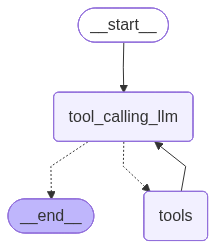

In [120]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [126]:
messages=graph.invoke({"messages":HumanMessage(content="add 5 and 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 5 and 10
================================== Ai Message ==================================
Tool Calls:
  add (y181rydbn)
 Call ID: y181rydbn
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: add

15
================================== Ai Message ==================================

The result of adding 5 and 10 is 15.


In [129]:
messages=graph.invoke({"messages":HumanMessage(content="multiple 2 and 5 and give me the half of the product's news regarding ai")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

multiple 2 and 5 and give me the news regarding ai
================================== Ai Message ==================================
Tool Calls:
  multiply (7pj593kma)
 Call ID: 7pj593kma
  Args:
    a: 2
    b: 5
  tavily_search_results_json (wny7bt5t5)
 Call ID: wny7bt5t5
  Args:
    query: AI news related to product half of 10
================================= Tool Message =================================
Name: multiply

10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Shoppers Warm to AI: 45% Say They Don't Care if Product Picks ...", "url": "https://www.prnewswire.com/news-releases/shoppers-warm-to-ai-45-say-they-dont-care-if-product-picks-come-from-humans-or-algorithms-constructor-shopify-report-finds-302559507.html", "content": "SAN FRANCISCO and CHICAGO, Sept. 18, 2025 /PRNewswire/ -- AI isn't just for writing emails 

## Adding memory to chatbot

In [148]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph_memory = builder.compile(checkpointer=memory)

In [149]:
config={"configurable":{"thread_id":"1"}}

message = [HumanMessage(content="multiple 2 and 5 ")]
messages_mem=graph_memory.invoke({"messages":message},config=config)
for m in messages_mem['messages']:
    m.pretty_print()

================================ Human Message =================================

multiple 2 and 5 
================================== Ai Message ==================================
Tool Calls:
  multiply (cgm0t4gq1)
 Call ID: cgm0t4gq1
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================

The result of multiplying 2 and 5 is 10.


In [150]:
message = [HumanMessage(content="divide it by 2 ")]
messages_mem=graph_memory.invoke({"messages":message},config=config)
for m in messages_mem['messages']:
    m.pretty_print()

================================ Human Message =================================

multiple 2 and 5 
================================== Ai Message ==================================
Tool Calls:
  multiply (cgm0t4gq1)
 Call ID: cgm0t4gq1
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================

The result of multiplying 2 and 5 is 10.
================================ Human Message =================================

divide it by 2 
================================== Ai Message ==================================
Tool Calls:
  divide (hymfa3q5n)
 Call ID: hymfa3q5n
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: divide

5.0
================================== Ai Message ==================================

The result of dividing 10 by 2 is 5.0.


In [151]:
message = [HumanMessage(content="multiply by 6")]
messages_mem=graph_memory.invoke({"messages":message},config=config)
for m in messages_mem['messages']:
    m.pretty_print()

================================ Human Message =================================

multiple 2 and 5 
================================== Ai Message ==================================
Tool Calls:
  multiply (cgm0t4gq1)
 Call ID: cgm0t4gq1
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================

The result of multiplying 2 and 5 is 10.
================================ Human Message =================================

divide it by 2 
================================== Ai Message ==================================
Tool Calls:
  divide (hymfa3q5n)
 Call ID: hymfa3q5n
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: divide

5.0
================================== Ai Message ==================================

The result of dividing 10 by 2 is 5.0.
================================ Hum